In [64]:
#This Notebook allows for us to optimize the Benchmarking by only transpiling once:
from mqt.bench import get_benchmark
from qiskit import QuantumCircuit, Aer, execute, assemble
from qiskit.providers.fake_provider import FakeSherbrooke
from qiskit.compiler import transpile
from qiskit.visualization import plot_gate_map
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import matplotlib.pyplot as plt
import numpy as np
import os
import re

#PREFORM SORTING of CIRCUITS:
def sort_circuit(circuits):
    for i in range(len(circuits)):
        min_qubits = circuits[i].num_qubits
        for j in range(len(circuits)):
            temp_qubits = circuits[j].num_qubits
            if min_qubits < temp_qubits:
                min_qubits = temp_qubits
                qc = circuits[i]
                circuits[i] = circuits[j]
                circuits[j] = qc
    
#File Reader Method--> Maybe what we can do is make this method return a map that has a specific optimization level point to a list of circuits. That could work.
def file_reader(file_path):
    backend = FakeSherbrooke()
    circuits = []
    optimization_level= {3: [],2: [], 1: []}
    directory = file_path
    for circuit in os.listdir(directory):
        circuit_path = f"{file_path}/{circuit}"
        if(circuit_path.endswith('.qasm')):
            print(circuit_path)
            qc = QuantumCircuit.from_qasm_file(circuit_path)
            circuits.append(qc)
            
    #Sorts Circuits Before Transpiling:
    sort_circuit(circuits)
        
    counter = 0
    for circuit in circuits:
        qc1 = transpile(circuit, optimization_level= 1, seed_transpiler= 42, backend=backend)
        qc2 = transpile(circuit, optimization_level= 2, seed_transpiler= 42, backend=backend)
        qc3 = transpile(circuit, optimization_level= 3, seed_transpiler= 42, backend=backend)
        optimization_level[1].append(qc1)
        optimization_level[2].append(qc2)
        optimization_level[3].append(qc3)
        print(f"circuit index: {counter} :completed")
        counter = counter + 1
        
    return optimization_level #Returns a Map, that has optimization Level pointing to a list of circuits corresponding to that 

In [65]:
import matplotlib.pyplot as plt
def num_single_and_multi_qubit_gates(circuit):
    Map = {'single' : 0, "multi" : 0}
    for gate in circuit.data:
        if len(gate[1]) == 1:
            Map['single'] = Map['single'] + 1
        else:
            Map['multi'] = Map['multi'] + 1
    return Map

def single_multi_ratio_benchmarking(optimization_levels):
    #These list will store the ratios (single // Multi ) of each circuit
    level1_list = []
    level2_list = []
    level3_list = []    
    return_list = []
    
    for i in range(len(optimization_levels[1])):
        
        level1_data = num_single_and_multi_qubit_gates(optimization_levels[1][i])
        level2_data = num_single_and_multi_qubit_gates(optimization_levels[2][i])
        level3_data = num_single_and_multi_qubit_gates(optimization_levels[3][i])
        
        #Step 3: Prepare ratio and list that contains all the data
        if level1_data['multi'] > 0:
            level1_ratio = level1_data['single'] / level1_data['multi']
            level1_list.append(level1_ratio)
        else:
            level1_list.append(level1_data['single'])
            
        if level2_data['multi'] > 0:
            level2_ratio = level2_data['single'] / level2_data['multi']
            level2_list.append(level2_ratio)
        else:
            level2_list.append(level1_data['single'])
            
        if level3_data['multi'] > 0:
            level3_ratio = level3_data['single'] / level3_data['multi']
            level3_list.append(level3_ratio)
        else:
            level3_list.append(level1_data['single'])
    
        
    return_list.append(level1_list), return_list.append(level2_list), return_list.append(level3_list)
    number_of_circuits = [i + 2 for i in range(len(optimization_levels[1]))]
    
    x = np.array(number_of_circuits)
    
    #Calculating Line of BEST FIT: Optimization Level 1
    a, b = np.polyfit(x, np.array(level1_list), 1)
    #Calculating Line of BEST FIT: Optimization Level 2
    c, d = np.polyfit(x, np.array(level2_list), 1)
    #Calculating Line of BEST Fit: Optimization Lebel 3
    e, f = np.polyfit(x, np.array(level3_list), 1)
    
    #--> Optimization Level 1.. etc lols
    plt.scatter(number_of_circuits, level1_list , label = "Optimization Level 1")    
    plt.plot(x, a*x+b) 
    print("The rate of change for optimization Level 1 is: ", a)
    print("The y-intercept for optimization level 1 is: ", b)
    plt.scatter(number_of_circuits, level2_list, label = "Optimization Level 2")
    plt.plot(x, c*x+d)  
    print("The rate of change for optimization level 2 is: ", c)
    print("The y-intercept for optimization level 2 is: ", d)
    plt.scatter(number_of_circuits, level3_list, label = "Optimization Level 3")
    print("The rate of change for optimization level 3 is: ", e)
    print("The y-intercept for optimization level 3 is: ", f)
    plt.plot(x, e*x+f)  
    plt.title("Transpilation Single Qubit to Multi Qubit gates")
    plt.xlabel('Number of Qubits')
    plt.ylabel('Ratio: (Single | Multi)' )
    plt.legend()
    plt.show()  

In [ ]:
def gate_count(optimization_levels):
    # Transpile each circuit, count the gates, and store the results
    opt1 = []
    opt2 = []
    opt3 = []
    for i in range(len(optimization_levels[1])):
        # stores the number of gates 

        # counts the number of gates in a given circuit
        opt1_count = optimization_levels[1][i].count_ops()
        opt2_count = optimization_levels[2][i].count_ops()
        opt3_count = optimization_levels[3][i].count_ops()

        # appends our count of the transpiled circuit to the array
        opt1.append(sum(opt1_count.values()))
        opt2.append(sum(opt2_count.values()))
        opt3.append(sum(opt3_count.values()))

    # Generate a graph to visualize the gate counts for optimization level 1
    plt.plot(range(1, len(optimization_levels[1]) + 1), opt1, label = "Optimization Level 1")
    plt.plot(range(1, len(optimization_levels[2]) + 1), opt2, label = "Optimization Level 2")
    plt.plot(range(1, len(optimization_levels[3]) + 1), opt3, label = "Optimization Level 3")
    plt.xlabel('Number of Qubits')
    plt.ylabel('Gate Count')
    plt.title('Gate Count of Transpiled Circuits')
    plt.xticks(range(1, len(optimization_levels[1]) + 1))
    plt.legend()
    plt.show()



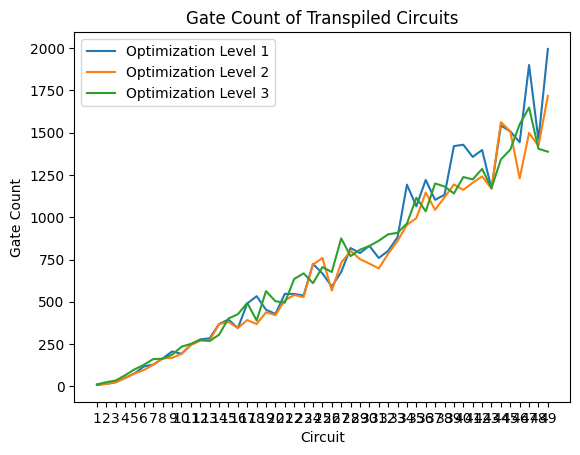

In [ ]:
gate_count(Map)

In [ ]:
#Another benchmarking tool is possibly to count the number of swap gates inserted into the circuit after transpilation, specifically it might be interesting to see how the 
#Number of swap gates change when you increase the number of qubits used in the circuit. 

#Swap is not a native instruction on most backends, CallBack Function --> Gives us data from each pass: Makes is much slower. 
from qiskit.converters import dag_to_circuit

from qiskit.providers.fake_provider import FakeNairobiV2

backend = FakeNairobiV2()

def callback(**kwargs):
    pass_ = kwargs['pass_'] #Gets the pass that is being run
    dag = dag_to_circuit(kwargs['dag']) #This makes the DAG into a circuit
    time = kwargs['time'] #I think this is giving the individual time of each pass
    property_set = kwargs['property_set'] 
    count = kwargs['count'] #I think this is giving the amount of opperations performed during the passes (indexing the passes)
    return pass_
    
def Callback(**kwargs):
    print(kwargs["pass_"])
    print(dag_to_circuit((kwargs["dag"]))) #Returns a DAG circuit object
    
    

circuit = QuantumCircuit(7)
circuit.h(0)
circuit.cx(4, 0)
circuit.cx(5, 1)
circuit.cx(6, 2)
circuit.cx(1, 4)
circuit.cx(1, 2)
circuit.cx(1, 3)
circuit.cx(0, 2)
circuit.cx(0, 3)
circuit.cx(3, 4)
circuit.cx(3, 5)
circuit.cx(3, 6)
circuit.cx(0, 4)
circuit.cx(0, 5)
circuit.cx(0, 6)

new_circuit = transpile(circuit, backend, layout_method='trivial', routing_method='lookahead', basis_gates=backend.operation_names + ["swap"], callback=Callback)

     ┌───┐     ┌───┐                                                       
q_0: ┤ H ├─────┤ X ├────────────■─────────■─────────■─────────■─────────■──
     ├───┤     └─┬─┘            │         │         │         │         │  
q_1: ┤ X ├───────┼────■────■────┼────■────┼─────────┼─────────┼─────────┼──
     └─┬─┘┌───┐  │    │  ┌─┴─┐┌─┴─┐  │    │         │         │         │  
q_2: ──┼──┤ X ├──┼────┼──┤ X ├┤ X ├──┼────┼─────────┼─────────┼─────────┼──
       │  └─┬─┘  │    │  └───┘└───┘┌─┴─┐┌─┴─┐       │         │         │  
q_3: ──┼────┼────┼────┼────────────┤ X ├┤ X ├──■────┼────■────┼────■────┼──
       │    │    │  ┌─┴─┐          └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │  
q_4: ──┼────┼────■──┤ X ├────────────────────┤ X ├┤ X ├──┼────┼────┼────┼──
       │    │       └───┘                    └───┘└───┘┌─┴─┐┌─┴─┐  │    │  
q_5: ──■────┼──────────────────────────────────────────┤ X ├┤ X ├──┼────┼──
            │                                          └───┘└───┘┌─┴─┐┌─┴─┐
q_6: ───────

In [1]:
new_circuit.__dir__()

NameError: name 'new_circuit' is not defined

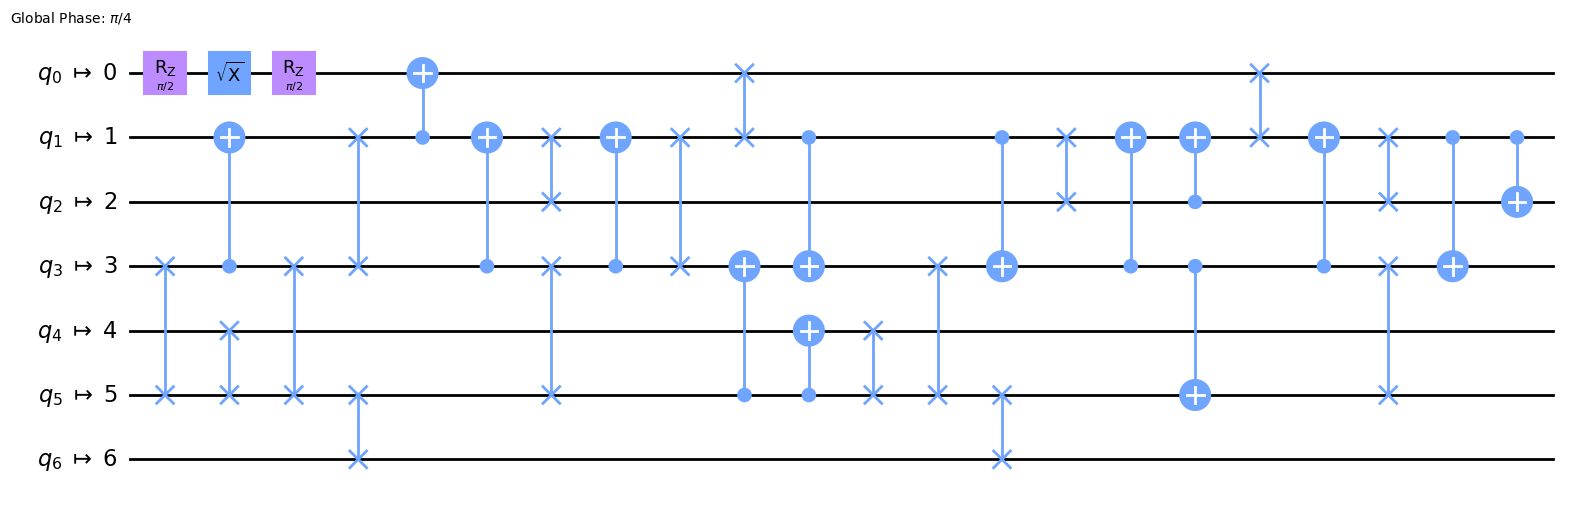

In [63]:
new_circuit.draw('mpl')

In [96]:
new_circuit.count_ops()['swap']

16

In [104]:
from mqt.bench import get_benchmark
from qiskit import QuantumCircuit, Aer, execute, assemble
from qiskit.providers.fake_provider import FakeSherbrooke
from qiskit.compiler import transpile
from qiskit.visualization import plot_gate_map
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
import time
import os
from statistics import mean
import matplotlib.pyplot as plt



#Sorts circuits from least Qubits to most Qubits
def sort_circuit(circuits):
    for i in range(len(circuits)):
        min_qubits = circuits[i].num_qubits
        for j in range(len(circuits)):
            temp_qubits = circuits[j].num_qubits
            if min_qubits < temp_qubits:
                min_qubits = temp_qubits
                qc = circuits[i]
                circuits[i] = circuits[j]
                circuits[j] = qc

#Reads in a directory of QASM files and returns a list of quantum circuit objects
def file_reader(file_path):
    circuits = []
    directory = file_path
    for circuit in os.listdir(directory):
        circuit_path = f"{file_path}/{circuit}"
        if(circuit_path.endswith('.qasm')):
            print(circuit_path)
            qc = QuantumCircuit.from_qasm_file(circuit_path)
            circuits.append(qc)
            
    #Sorts Circuits Before Transpiling:
    sort_circuit(circuits)
    return circuits

#This calculates runtimes and returns a completed analysis of a directory of circuits. 
#THIS METHOD ALSO returns a MAPPING of all circuits to a corresponding optimization level.
def runtime_benchmarking(NUM_ITERATIONS, circuits, the_backend):
    
    BACKEND = the_backend
    Optimization_Levels = {3: [], 2: [], 1: [], 0: []}

    #These array will store:   
    mean_transpile_times_1 = []
    mean_transpile_times_2 = []
    mean_transpile_times_3 = []

    for index, circuit in enumerate(circuits):
        
        transpiled = False

        iteration_times_1 = []
        iteration_times_2 = []
        iteration_times_3 = []

        for _ in range(NUM_ITERATIONS):

            #Transpilation Level 1:
            start_time = time.perf_counter()
            qc1 = transpile(circuit, optimization_level= 1, seed_transpiler= 42, backend=BACKEND)
            stop_time = time.perf_counter()
            iteration_times_1.append(stop_time - start_time) 

            #Transpilation Level 2:
            start_time = time.perf_counter()
            qc2 = transpile(circuit, optimization_level= 2, seed_transpiler= 42, backend=BACKEND)
            stop_time = time.perf_counter()
            iteration_times_2.append(stop_time - start_time) #stores in temp array five values

            #Transpilation Level 3:
            start_time = time.perf_counter()
            qc3 = transpile(circuit, optimization_level= 3, seed_transpiler= 42, backend=BACKEND)
            stop_time = time.perf_counter()
            iteration_times_3.append(stop_time - start_time) #stores in temp array five values

            #If this is the first iteration, then we simply add the circuits to the dictonary
            if transpiled == False:

                Optimization_Levels[3].append(qc3)
                Optimization_Levels[2].append(qc2)
                Optimization_Levels[1].append(qc1)
                Optimization_Levels[0].append(circuit)
                transpiled = True

        #At this point all the data has been added to iteration_times. Now it is just a matter of extracting data. 
        mean_transpile_times_1.append(mean(iteration_times_1))
        mean_transpile_times_2.append(mean(iteration_times_2))
        mean_transpile_times_3.append(mean(iteration_times_3))

        print("Circuit Index Completed: ", index)
    #Scatter Plot for Runtime after all values are collected
    plt.figure(figsize=(12, 6))

    #Number of qubits in the sorted circuit
    number_of_qubits = [i + 2 for i in range(len(mean_transpile_times_1))] #num of qubits 

    x = np.array(number_of_qubits)

    #Calculating Line of BEST FIT: Optimization Level 1
    a, b = np.polyfit(x, np.array(mean_transpile_times_1), 1)
    #Calculating Line of BEST FIT: Optimization Level 2
    c, d = np.polyfit(x, np.array(mean_transpile_times_2), 1)
    #Calculating Line of BEST Fit: Optimization Level 3
    e, f = np.polyfit(x, np.array(mean_transpile_times_3), 1)


    plt.scatter(number_of_qubits, mean_transpile_times_1, label = "Average of Opt Level 1")
    plt.plot(x, a*x+b)
    plt.scatter(number_of_qubits, mean_transpile_times_2, label = "Average of Opt Level 2")
    plt.plot(x, c*x+d)
    plt.scatter(number_of_qubits, mean_transpile_times_3, label = "Average of Opt Level 3")
    plt.plot(x, e*x+f)
    plt.xlabel('Number of Qubits')
    plt.ylabel('Runtime in Seconds')
    plt.title('Runtime in Seconds (at each opt level)')
    plt.legend()
    plt.show()

    return Optimization_Levels

circuits = file_reader("/Users/noelnegron/QXQ_transpiler_benchmarking/MQT_Circuits")

/Users/noelnegron/QXQ_transpiler_benchmarking/MQT_Circuits/qftentangled_indep_qiskit_85.qasm
/Users/noelnegron/QXQ_transpiler_benchmarking/MQT_Circuits/qft_indep_qiskit_116.qasm
/Users/noelnegron/QXQ_transpiler_benchmarking/MQT_Circuits/qftentangled_indep_qiskit_112.qasm
/Users/noelnegron/QXQ_transpiler_benchmarking/MQT_Circuits/qftentangled_indep_qiskit_93.qasm
/Users/noelnegron/QXQ_transpiler_benchmarking/MQT_Circuits/vqe_indep_qiskit_11.qasm
/Users/noelnegron/QXQ_transpiler_benchmarking/MQT_Circuits/qft_indep_qiskit_100.qasm
/Users/noelnegron/QXQ_transpiler_benchmarking/MQT_Circuits/su2random_indep_qiskit_108.qasm
/Users/noelnegron/QXQ_transpiler_benchmarking/MQT_Circuits/qftentangled_indep_qiskit_104.qasm
/Users/noelnegron/QXQ_transpiler_benchmarking/MQT_Circuits/qftentangled_indep_qiskit_50.qasm
/Users/noelnegron/QXQ_transpiler_benchmarking/MQT_Circuits/qft_indep_qiskit_76.qasm
/Users/noelnegron/QXQ_transpiler_benchmarking/MQT_Circuits/qft_indep_qiskit_99.qasm
/Users/noelnegron/QX

In [100]:
def count_swap_gates(optimization_levels):
    
    level1_list = []
    level2_list = []
    level3_list = []
    
    #make a return dictonary to see what the levels are outputting
    dic = { 3: level3_list,
            2: level2_list,
            1: level1_list}
    
    for i in range(len(optimization_levels[1])):
        if optimization_levels[1][i].count_ops().__contains__('swap'):
            level1_list.append(optimization_levels[1][i].count_ops()['swap'])
        else:
            level1_list.append(0)
        if optimization_levels[2][i].count_ops().__contains__('swap'):
            level2_list.append(optimization_levels[2][i].count_ops()['swap'])
        else:
            level2_list.append(0)
        if optimization_levels[3][i].count_ops().__contains__('swap'):
            level3_list.append(optimization_levels[3][i].count_ops()['swap'])
        else:
            level3_list.append(0)
        
    number_of_qubits= [i + 2 for i in range(len(optimization_levels[1]))]
    
    x = np.array(number_of_qubits)
    
    #Calculating Line of BEST FIT: Optimization Level 1
    a, b = np.polyfit(x, np.array(level1_list), 1)
    #Calculating Line of BEST FIT: Optimization Level 2
    c, d = np.polyfit(x, np.array(level2_list), 1)
    #Calculating Line of BEST Fit: Optimization Lebel 3
    e, f = np.polyfit(x, np.array(level3_list), 1)
    
    #--> Optimization Level 1.. etc lols
    plt.scatter(number_of_qubits, level1_list , label = "Optimization Level 1")    
    plt.plot(x, a*x+b) 
    print("The rate of change for optimization Level 1 is: ", a)
    print("The y-intercept for optimization level 1 is: ", b)
    plt.scatter(number_of_qubits, level2_list, label = "Optimization Level 2")
    plt.plot(x, c*x+d)  
    print("The rate of change for optimization level 2 is: ", c)
    print("The y-intercept for optimization level 2 is: ", d)
    plt.scatter(number_of_qubits, level3_list, label = "Optimization Level 3")
    print("The rate of change for optimization level 3 is: ", e)
    print("The y-intercept for optimization level 3 is: ", f)
    plt.plot(x, e*x+f)  
    plt.title("Number of Swap Gates For Preset Passmanagers")
    plt.xlabel('Number of Qubits')
    plt.ylabel('Number of SwapGates' )
    plt.legend()
    plt.show()  
    return dic